# Lead and Tungsten Configuration

## Loading the MDF Objects

The calibration data MDF object.

In [1]:
from MuDataFrame import *

mdfo_calib = MuDataFrame("/Volumes/mac_extended/Research/MT/proto1b/data_sets/calibration_data/calibration_data_updated.csv")
mdf_calib = mdfo_calib.events_df
mdfo_calib.og_df = mdf_calib.copy()
#mdfo_calib.show()

The new config data MDF object.

In [2]:
from MuDataFrame import *
import copy

r1,r2 = 561, 576
path = "/Volumes/mac_extended/Research/MT/proto1b/data_sets/lead_tungsten/run{}.csv"
#path = "processed_data/run{}.csv"
lead_files = [path.format(i) for i in range(r1,r2+1)]

mdfo_c = [] #collection of objects

for file in lead_files:
    mdfo_c.append(MuDataFrame(file)) #Muon Data Frame Object for Lead

mdf_list = [i.events_df for i in mdfo_c]
mdf_lead = mdfo_c[0].getMergedMDF(mdf_list)

mdfo_lead = copy.copy(mdfo_c[0])
mdfo_lead.events_df = mdf_lead

mdfo_lead.longDataMode()

mdf_lead = mdfo_lead.events_df
mdfo_lead.og_df = mdf_lead.copy()
mdfo_lead.show()

,index,event_num,event_time,deadtime,l1hit,l2hit,l3hit,l4hit,r1hit,r2hit,...,z_angle,SmallCounter,speed,Run_Num,xx,yy,xx1,yy1,time_of_day,time
0,0,0,2021-04-08 18:29:47.867809,0,1.0,1.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,561,NaN,NaN,NaN,NaN,night,0
1,1,1,2021-04-08 18:29:48.058071,0,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,561,-3.367541,NaN,-3.676923,NaN,night,190262
2,2,2,2021-04-08 18:29:48.157999,0,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,561,-29.905303,NaN,-31.930769,NaN,night,290190
3,3,3,2021-04-08 18:29:48.448220,0,1.0,1.0,1.0,1.0,1.0,1.0,...,7.575641,NaN,0.793181,561,-26.936937,-1.579660,-27.600000,-1.500000,night,580411
4,4,4,2021-04-08 18:29:48.978166,0,1.0,1.0,1.0,1.0,1.0,1.0,...,12.551636,NaN,0.402755,561,-1.568519,30.342518,-2.046154,27.946154,night,1110357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597574,99995,1597574,2021-04-15 09:00:40.848924,0,1.0,1.0,1.0,1.0,1.0,1.0,...,16.492489,NaN,0.266975,576,27.113752,21.226568,28.384615,22.384615,day,495443981115
1597575,99996,1597575,2021-04-15 09:00:41.358804,0,1.0,1.0,1.0,1.0,1.0,1.0,...,16.969530,NaN,0.500378,576,-13.405362,35.613686,-13.023077,35.407692,day,495444490995
1597576,99997,1597576,2021-04-15 09:00:41.839039,0,0.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,576,NaN,NaN,NaN,NaN,day,495444971230
1597577,99998,1597577,2021-04-15 09:00:42.009224,0,1.0,1.0,1.0,0.0,1.0,1.0,...,NaN,NaN,NaN,576,35.836907,NaN,36.130769,NaN,day,495445141415


## Generating Tomograms

### Helper Functions

In [5]:
import copy

def getXatZPlane_diffTDC(x1, x2, zplane, dsep):
    x = (zplane / dsep) * (
        getPhysicalUnitsFromDiffTDC(x1) -
        getPhysicalUnitsFromDiffTDC(x2)) + getPhysicalUnitsFromDiffTDC(x1)
    return x

def getPhysicalUnitsFromDiffTDC(tdc):
    return (55 / 130) * tdc

def getSameShapeDataSets(mdfo1, mdfo2):
    mdfo1 =  copy.copy(mdfo1)
    mdfo2 = copy.copy(mdfo2)
    s1 = len(mdfo1.events_df.index)
    s2 = len(mdfo2.events_df.index)
    s = min(s1,s2)
    mdfo1.events_df =  mdfo1.events_df.iloc[:s]
    mdfo2.events_df =  mdfo2.events_df.iloc[:s]
    return mdfo1, mdfo2

def getSameSizeData(mdfo1, mdfo2, data_term):
    mdfo1, mdfo2 = getSameShapeDataSets(mdfo1, mdfo2)
    return mdfo1.get(data_term), mdfo2.get(data_term)

def getRatioPlot( xviews, yviews, axes=[-30,30], bins=(15,15),title="Data"):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    h = h1 / h2
 #   h[h >= 1.15] = 1.15
 #   h[h <= 0.8] = 0.8
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, h.T)
    plt.title("Reco Z plane XY View Ratio ({})".format(title),fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.show()


def getNormalizedRatioPlot( xviews, yviews, axes=[-30,30], bins=(15,15),title="Data"):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    normH1 = (1/(h1[int(np.floor(h1.shape[0]/2))][int(np.floor(h1.shape[1]/2))]))*h1
    normH2 = (1/(h2[int(np.floor(h2.shape[0]/2))][int(np.floor(h2.shape[1]/2))]))*h2
    h = normH1 / normH2
 #   h[h >= 1.15] = 1.15
 #   h[h <= 0.8] = 0.8
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, h.T)
    plt.title("Reco Z plane XY View Ratio ({})".format(title),fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.savefig("tomograms/tomogram_lead_tungsten_{}.png".format(title.strip()))
  #  plt.show()

    
def getNormalizedRatioPlotMatrix( xviews, yviews, axes=[-30,30], bins=(15,15),title="Data"):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    normH1 = (1/(h1[int(np.floor(h1.shape[0]/2))][int(np.floor(h1.shape[1]/2))]))*h1
    normH2 = (1/(h2[int(np.floor(h2.shape[0]/2))][int(np.floor(h2.shape[1]/2))]))*h2
    h = normH1 / normH2
 #   h[h >= 1.15] = 1.15
 #   h[h <= 0.8] = 0.8
    return h.T
    
def getNormalizedRatioPlot_nonCenter( xviews, yviews, axes=[-30,30], bins=(15,15),title="Data"):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    normH1 = (1/(h1[int(np.floor(h1.shape[0]/2))][int(np.floor(h1.shape[1]/2))]))*h1
    normH2 = (1/(h2[int(np.floor(h2.shape[0]/2))][int(np.floor(h2.shape[1]/2))]))*h2
    h = normH1 / normH2
 #   h[h >= 1.15] = 1.15
 #   h[h <= 0.8] = 0.8
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, h.T)
    plt.title("Reco Z plane XY View Ratio ({})".format(title),fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.savefig("tomograms/tomogram_{}.png".format(title.strip()))
  #  plt.show()
    
    
def getNormalizedRatioPlot( xviews, yviews, axes=[-30,30], bins=(15,15),title="Data"):
    xx_lead, xx_calib = xviews
    yy_lead, yy_calib = yviews
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xx_lead, yy_lead, bins=bins, range=ranges)
    h2, xedges, yedges = np.histogram2d(xx_calib, yy_calib, bins=bins, range=ranges)
    normH1 = (1/(h1[int(np.floor(h1.shape[0]/2))][int(np.floor(h1.shape[1]/2))]))*h1
    normH2 = (1/(h2[int(np.floor(h2.shape[0]/2))][int(np.floor(h2.shape[1]/2))]))*h2
    h = normH1 / normH2
 #   h[h >= 1.15] = 1.15
 #   h[h <= 0.8] = 0.8
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, h.T)
    plt.title("Reco Z plane XY View Ratio ({})".format(title),fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.savefig("tomograms/tomogram_{}.png".format(title.strip()))
   # plt.show()
    
    
def getTomogramMatrix(xview, yview, axes=[-30,30], bins=(15,15),title="Data"):
    ranges = (axes,axes)
    h1, xedges, yedges = np.histogram2d(xview, yview, bins=bins, range=ranges)
    normH = (1/(h1[int(np.floor(h1.shape[0]/2))][int(np.floor(h1.shape[1]/2))]))*h1
   # return normH, , xedges, yedges
    fig, ax = plt.subplots(1)
    pc = ax.pcolorfast(xedges, yedges, normH.T)
    plt.title("Reco Z plane XY View ({})".format(title),fontsize=15)
    plt.xlabel("X (cm)")
    plt.ylabel("Y (cm)")
    plt.colorbar(pc)
    plt.show()

## Tomograms at different binning

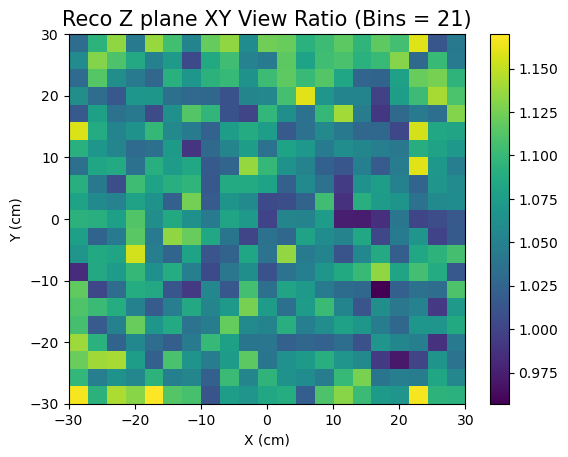

In [4]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()

mdfo_calib.reload()
mdfo_calib.keep4by4Events()

xx_lead, yy_lead = mdfo_lead.get("xx1"), mdfo_lead.get("yy1")
xx_calib, yy_calib = mdfo_calib.get("xx1"), mdfo_calib.get("yy1")

binn = 21

getNormalizedRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib],bins=(binn,binn),axes=[-30,30],title="Bins = {}".format(binn))

In [6]:
mdfo_lead.reload()
mdfo_lead.keep4by4Events()

mdfo_calib.reload()
mdfo_calib.keep4by4Events()

xx_lead, yy_lead = mdfo_lead.get("xx1"), mdfo_lead.get("yy1")
xx_calib, yy_calib = mdfo_calib.get("xx1"), mdfo_calib.get("yy1")

image_list = []

for binn in range(9,33,2):
    image_list.append("tomograms/tomogram_{}.png".format("Bins = {}".format(binn).strip()))
    getNormalizedRatioPlot([xx_lead,xx_calib],[yy_lead,yy_calib],bins=(binn,binn),axes=[-30,30],title="Bins = {}".format(binn))

In [12]:
from PIL import Image
  
im_list = []
    
for i in image_list:
    im_list.append(Image.open(i))

pdf1_filename = "tomograms/tomogram_different_bins.pdf"

im_list[0].save(pdf1_filename, "PDF" ,resolution=100.0, save_all=True, append_images=im_list)

ValueError: cannot save mode RGBA

In [17]:
import os
import img2pdf

with open("tomograms/tomogram_different_bins.pdf", "wb") as f:
    f.write(img2pdf.convert([i for i in image_list]))

AlphaChannelError: Refusing to work on images with alpha channel